In [7]:
import scale.olm
import pathlib
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# Load a reactor library.
path = pathlib.Path('/Users/ww5/olm/collection/w17x17/_work/arpdata.txt')
name = 'w17x17'
rl = scale.olm.core.ReactorLibrary(path,name)

[ 2  1 32]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 21.70it/s]


In [9]:
# Understand the axes.
print(rl.axes_names)
print(rl.axes_shape)
print(rl.axes_values)

['enrichment' 'mod_dens' 'times']
[ 2  1 32]
[array([4. , 8.5]), array([0.723]), array([0.0000000e+00, 2.0000000e+01, 5.4000000e+02, 2.0200000e+03,
       4.0000000e+03, 6.2500000e+03, 8.9999990e+03, 1.2000000e+04,
       1.5000001e+04, 1.7999998e+04, 2.1000000e+04, 2.4000000e+04,
       2.7000000e+04, 3.0000002e+04, 3.3000000e+04, 3.5999996e+04,
       3.9000000e+04, 4.2000000e+04, 4.5000000e+04, 4.8000000e+04,
       5.1000000e+04, 5.4000000e+04, 5.7000000e+04, 6.0000004e+04,
       6.3000000e+04, 6.6000000e+04, 6.9000000e+04, 7.1999992e+04,
       7.5000000e+04, 7.8000000e+04, 8.1000000e+04, 8.4000000e+04],
      dtype=float32)]


In [10]:
# You need these environment variables corresponding to your setup. This happens after you run
# olm create config.olm.json to generate the work directory with its files.
_env={
    "config_file": "/Users/ww5/olm/collection/w17x17/config.olm.json",
    "work_dir": "/Users/ww5/olm/collection/w17x17/_work",
    "scalerte": "/Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte",
    "obiwan": "/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan",
    "nprocs": 3
}
_model={
    "name":"w17x17",
    "description":"Library Westinghouse 17x17 design",
    "sources":{
        
    },
    "revision":[
        "1.0"
    ],
    "notes":[
        
    ]
}

2024-10-30 19:52:55 [info     ] check LowOrderConsistency      template_file=/Users/ww5/olm/scale/olm/templates/model/origami/system-uox.jt.inp
2024-10-30 19:52:55 [info     ] Running SCALE                  version=6.3.2
2024-10-30 19:52:55 [info     ] Running external               command_line=cd /Users/ww5/olm/collection/w17x17/_work/check/check1 && make -j 3
2024-10-30 19:52:55 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0400w0723/w17x17_e0400w0723.inp
2024-10-30 19:52:55 [info     ] /Applications/SCALE-6.3.2.app/Contents/Resources/bin/scalerte w17x17_e0850w0723/w17x17_e0850w0723.inp
2024-10-30 19:53:08 [info     ]                               
2024-10-30 19:53:08 [info     ] Running external               command_line=/Applications/SCALE-6.3.2.app/Contents/Resources/bin/obiwan view -format=ii.json /Users/ww5/olm/collection/w17x17/_work/check/check1/w17x17_e0400w0723/w17x17_e0400w0723.f71 -cases='[1]'
2024-10-30 19:53:08 [info     ] Running ex

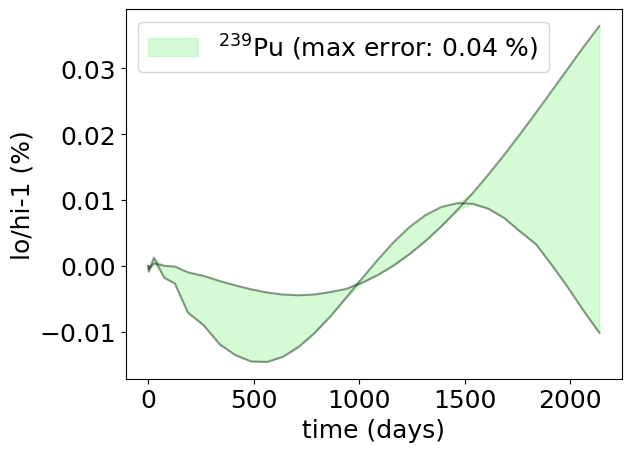

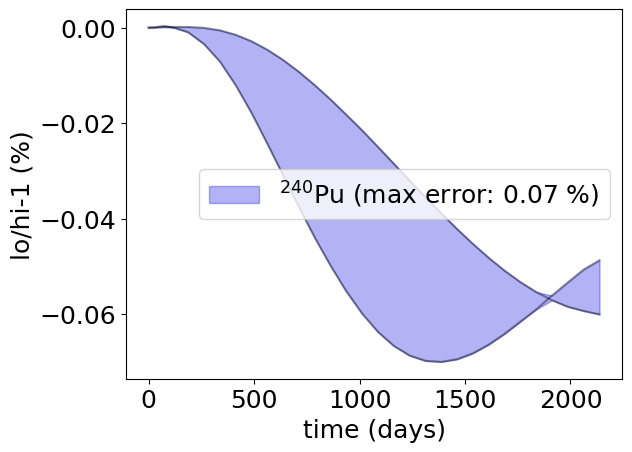

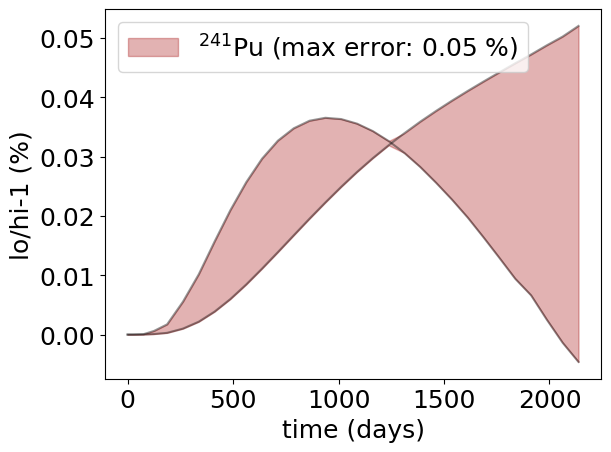

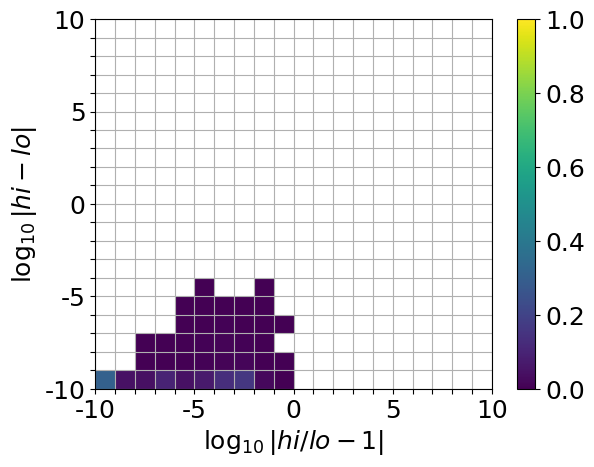

In [11]:
# Setup the check runner and run the check.
check = scale.olm.check.LowOrderConsistency(
                        name='check1',
                        _env=_env,
                        _model=_model,
                        template='model/origami/system-uox.jt.inp', 
                        nuclide_compare=['pu239','pu240','pu241']
)
info = check.run(rl)